# Generate diffusion on external dictionary from Distrib Simulations

In [75]:
import matlab.engine

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import h5py


# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from math import pi
from keras.models import Model
from tensorflow.keras.optimizers import Adam # - Works

import scipy.io
# eng = matlab.engine.start_matlab()
import mat73

from tqdm import tqdm  # Import tqdm for the progress bar
import time

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.io import savemat
from tensorflow.keras.regularizers import l2

In [76]:
def load_dico_mat_concat(dico):
    presig = abs(dico['Dico']['MRSignals'][0][0][0][0])
    postsig = abs(dico['Dico']['MRSignals'][0][0][0][1])
    MRSignals = np.concatenate((presig, postsig), axis=1)[:, :, np.newaxis]
    return MRSignals

def load_dico_mat_classique(dico, contrast=None):
    if contrast == 'pre':
        MRSignals = abs(dico['Dico']['MRSignals'][0][0][0][0])[:, :, np.newaxis] #pre
    elif contrast=='post':
        MRSignals = abs(dico['Dico']['MRSignals'][0][0][0][1])[:, :, np.newaxis] #post
    return MRSignals

def load_dico_mat_classique_v73(dico, contrast=None):
    if contrast == 'pre':
        MRSignals = abs(dico['Dico']['MRSignals'][0])[:, :, np.newaxis]  # pre
    elif contrast == 'post':
        MRSignals = abs(dico['Dico']['MRSignals'][1])[:, :, np.newaxis]  # post
    return MRSignals

def load_dico_mat_onecontrast_v73(dico, contrast=None):
    MRSignals = abs(dico['Dico']['MRSignals'][0])[:, :, np.newaxis]  # pre
    return MRSignals

#Useful fonctions

def generate_dataset(parameters, nodiff_signal, diff_signal, sample_list, batch_size):
    Data_use = parameters[sample_list, :, :]
    diff_signal = diff_signal[sample_list, :, :]
    nodiff_signal = nodiff_signal[sample_list, :, :]
    
    dataset_input = tf.data.Dataset.from_tensor_slices((Data_use, nodiff_signal))
    dataset_label = tf.data.Dataset.from_tensor_slices(diff_signal)

    dataset_use = tf.data.Dataset.zip((dataset_input, dataset_label))
    
    dataset_use = dataset_use.batch(batch_size, drop_remainder=True)  # nTotal
#     dataset_use.shuffle(buffer_size=32, reshuffle_each_iteration=True)
    
    return dataset_use

def generate_testset(parameters, nodiff_signal, wtf_matrix, batch_size):
    dataset_input = tf.data.Dataset.from_tensor_slices((parameters, nodiff_signal))
    dataset_label = tf.data.Dataset.from_tensor_slices(wtf_matrix)

    dataset_use = tf.data.Dataset.zip((dataset_input, dataset_label))
    
    dataset_use = dataset_use.batch(batch_size, drop_remainder=True)  # nTotal
    dataset_use.shuffle(buffer_size=32, reshuffle_each_iteration=True)
    
    return dataset_use


def random_split_train_val_test(nb_FA, nVal_BatchSize, nBatch, nTrain):
    shuffle = np.random.permutation(nb_FA)
    Training_List = shuffle[0:nTrain - nVal_BatchSize * nBatch]
    Validation_List = shuffle[nTrain - nVal_BatchSize * nBatch:nTrain]
    Test_List = shuffle[nTrain:nb_FA]  # range(0,nTotal * type_rf) #
    
    return Training_List, Validation_List, Test_List

def fixed_split_train_val_test(nb_FA, nVal_BatchSize, nBatch, nTrain):
    shuffle = np.arange(nb_FA)
    Training_List = shuffle[0:nb_FA - nVal_BatchSize * nBatch:2]
    Validation_List = shuffle[nb_FA - nVal_BatchSize * nBatch:nb_FA:2]
    Test_List = shuffle[1::2]  # range(0,nTotal * type_rf) #
    
    return Training_List, Validation_List, Test_List

def buildGRU(input_dimA, input_dimB, output_dim, input_batch, rnn_units, n_pulses):
    
    inputsA = tf.keras.Input(shape=(n_pulses, input_dimA), batch_size = input_batch, name='Parameters (SO2, CBV, R, DH20)');
    inputsB = tf.keras.Input(shape=(n_pulses, input_dimB), batch_size = input_batch, name='No diffusion signal');

    gru1 = GRU(rnn_units,return_sequences=True, name='gru_1');
    gru2 = GRU(rnn_units,return_sequences=True, name='gru_2');
    gru3 = GRU(rnn_units,return_sequences=True, name='gru_3');
    
    x1 = gru1(tf.keras.layers.concatenate([inputsA, inputsB], name='concat_inputs'))
    x2 = gru2(x1)
    x3 = gru3(x2)
    x4 = Dense(output_dim, activation="sigmoid", name='dense_1')(x3)
#     f1 = Dense(units=output_dim, kernel_regularizer=l2(0.001), name='dense_2')(x4)

    return tf.keras.Model(inputs = [inputsA, inputsB], outputs = x4, name='GRU')

#normalize the signals
def normalize_signals_from_matrix(matrix, norm):
    matrix_normalized = np.zeros(matrix.shape)
    for i in range(matrix.shape[0]):
        if norm=='L1':
            matrix_normalized[i,:] = matrix[i,:]/np.linalg.norm(matrix[i,:],1)
        elif norm=='L2':
            matrix_normalized[i,:] = matrix[i,:]/np.linalg.norm(matrix[i,:],2)
        elif norm=='max':
            matrix_normalized[i] = matrix[i,:]/np.max(matrix[i,:])
        elif norm =='minmax':
            matrix_normalized[i] = (matrix[i,:]-np.amin(matrix[i,:]))/(np.amax(matrix[i,:])-np.amin(matrix[i,:]))
        elif norm=='stand':
            matrix_normalized[i,:] = (matrix[i,:]-np.mean(matrix[i,:]))/np.std(matrix[i,:])
    return matrix_normalized


def rmse(actual, predicted):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual, predicted):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())

# create a 2D plot with NRMSE as surface color
def plot_surface(ax, x, y, z, xlabel, ylabel, zlabel):
    sc = ax.scatter(x, y, c=z, cmap='viridis')
    plt.colorbar(sc, ax=ax, label=zlabel)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(f'{zlabel} as surface color', fontsize=18)
    


# LOAD MODEL PRE or POST (trained on 20,000 signals)

In [202]:
# model = tf.keras.models.load_model("New_sobol_RNNdiff_aurel_2000sigtrain_pre.hdf5")
# model = tf.keras.models.load_model(str1)
model = tf.keras.models.load_model("saved_models/RNNdiff_fixed_aurel_20Ksigtrain_pre.hdf5")


# Load a nodiff dictionary Pre or Post, make some format change and predict on it (directly from the python simulator)

In [203]:
dico_nodiff_test = mat73.loadmat("/data_network/summer/projects/Current/2021_MRF_TC/MRF_Simulations/dictionaries_thomas/Dico_GESFIDE_MRvF_135k_pre_zero/DICO.mat")
contrast='pre'
nodiff_signal_test = abs(dico_nodiff_test['Dico']['MRSignals'][0][:, :, np.newaxis])
param = dico_nodiff_test['Dico']['Parameters']['Par'] #SO2, VF,R 

print("Dictionary of {} loaded. Parameters:{}".format(nodiff_signal_test.shape[0], dico_nodiff_test['Dico']['Parameters']['Labels']))
voxelList = dico_nodiff_test['Dico']['VoxelList']

n_signals_test = nodiff_signal_test.shape[0]
nbatch=20

if n_signals_test % nbatch != 0: #### case where the nb of signals to predict is not multiple of batch size
    nodiff_signal_test = nodiff_signal_test[:n_signals_test-(n_signals_test % nbatch)]
#     diff_signal_test = diff_signal_test[:n_signals_test-(n_signals_test % nbatch)]
    param = param[:n_signals_test-(n_signals_test % nbatch)]
    n_signals_test -= n_signals_test % nbatch
    
################# sort the dico if necessary
parameters_for_sort2 = param #T1,T2,df,B1,SO2, VF,R 
# Sort first by the first column (SO2, indice 4), then by the second column (VF, indice 5)
sorted_indices2 = np.lexsort((parameters_for_sort2[:, 5], parameters_for_sort2[:, 4]))
sorted_parameters_for_sort2 = parameters_for_sort2[sorted_indices2]
sorted_parameters_for_sort2 = sorted_parameters_for_sort2[:, 4:] #remove T1,T2,df,B1

sorted_nodiff_signal_test = nodiff_signal_test[sorted_indices2]
nodiff_signal_test = sorted_nodiff_signal_test
voxelList_test = [voxelList[i] for i in sorted_indices2] ### also sort voxelList !
#####################

nodiff_signal_test = normalize_signals_from_matrix(nodiff_signal_test, 'L2')
n_pulses_test = nodiff_signal_test.shape[1]
parameters_test = sorted_parameters_for_sort2
parameters_test = np.repeat(parameters_test[:, np.newaxis, :], n_pulses_test, axis=1)[:, :,[1, 2, 0]] # from SO2, VF, R to VF, R, SO2

print(parameters_test[1,0,:]) 

wtf_matrix = np.ones(nodiff_signal_test.shape)*8000 # sert a rien mais jsp pq ça bug si c'est pas en input, à creuser
dataset_test = generate_testset(parameters_test, nodiff_signal_test, wtf_matrix, nbatch) #nbatch=20
print(dataset_test)
tic2 = time.time()
prediction_test = model.predict(dataset_test)
toc2 = time.time()

print("Predict Time is:",toc2-tic2)
print("prediction shape:", prediction_test.shape)

labelsfromdataset = np.concatenate([y for x, y in dataset_test], axis=0)

pred_norm = normalize_signals_from_matrix(prediction_test[:,:,0], 'L2')
# gt_norm = diff_signal_test
nodiff_norm = normalize_signals_from_matrix(nodiff_signal_test[:,:,0], 'L2')


Dictionary of 134571 loaded. Parameters:['T1', 'T2', 'df', 'B1rel', 'SO2', 'Vf', 'R']
[0.0231444  3.26832467 0.350012  ]
<BatchDataset shapes: (((20, 32, 3), (20, 32, 1)), (20, 32, 1)), types: ((tf.float64, tf.float64), tf.float64)>
Predict Time is: 10.1860830783844
prediction shape: (134560, 32, 1)


Signal 48753 used for plot


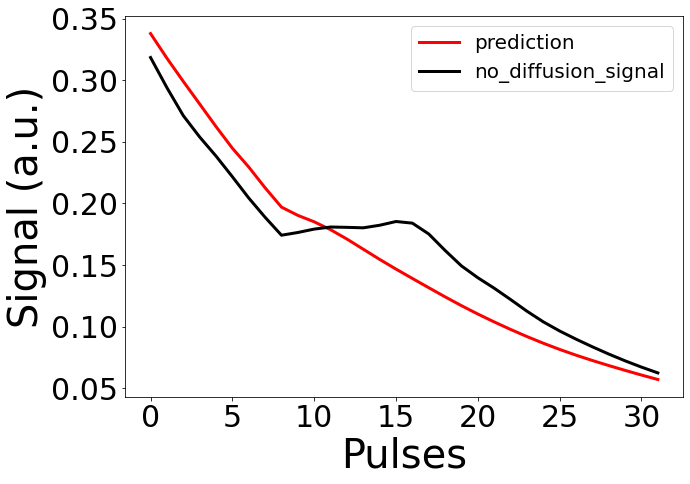

VF= 0.033774706846586774 R= 3.2242556118931494 , SO2= 0.566452339912703


In [209]:
##### COMPARABLE ONLY IF THE PARAMETERS ARE IN THE SAME ORDER

# show prediction example
# which_sample_to_test = np.random.choice(Test_List,1)[0]
which_sample_to_show = np.random.choice(n_signals_test,1)[0]
# which_sample_to_show = 520

# which_sample_to_test = 14130
print("Signal", which_sample_to_show, "used for plot")

font = {'color':  'black',
        'weight': 'normal',
        'size': 35,
        }
plt.rcParams["figure.figsize"] = (10,7)
fig = plt.figure(1)
plt.plot(pred_norm[which_sample_to_show],label='prediction', linewidth=3, color='r')
# plt.plot(gt_norm[which_sample_to_show],'--', label="ground_truth", linewidth=3, color='b')
plt.plot(nodiff_norm[which_sample_to_show], '-', label='no_diffusion_signal', linewidth=3, color='k')

plt.legend(prop={'size': 20})
# plt.title("MR signals", fontdict=font)
plt.xlabel('Pulses', fontsize=40, fontdict=font)
plt.xticks(fontsize=30)
plt.ylabel('Signal (a.u.)', fontsize=40, fontdict=font)
plt.yticks(fontsize=30)
# plt.grid()	#shows a grid under the plot
plt.show()
print("VF=",parameters_test[which_sample_to_show,:,0][0], "R=", parameters_test[which_sample_to_show,:,1][0], ", SO2=", parameters_test[which_sample_to_show,:,2][0])
# print("VF=",sorted_parameters_for_sort[which_sample_to_show,0], "R=", sorted_parameters_for_sort[which_sample_to_show,1], ", SO2=", sorted_parameters_for_sort[which_sample_to_show,2], ", DH2O=", sorted_parameters_for_sort[which_sample_to_show,-1])



# print("NMRSE=", nrmse(prediction_test[which_sample_to_show, :, 0],diff_signal_test[which_sample_to_show])*100, "%")

In [229]:
# Convert VoxelList to a list of strings
voxel_list_as_cell = [str(voxel) for voxel in np.array(voxelList_test)[:, 0]]

# Define the dictionary with variable names and arrays
data = {
    'Parameters': parameters_test,
    'Labels': ['Vf', 'R', 'SO2'],
    'MRSignals': prediction_test,
    'VoxelList': voxel_list_as_cell
}

# Save the data to a .mat file
save_path = "/data_network/summer/projects/Current/2021_MRF_TC/MRF_Simulations/dicoMRWAVES/RNN/Dico_GESFIDE_MRvF_135k_noT2_" + contrast + ".mat"
savemat(save_path, data)

# Code skipnet for validation (comparison between proposed method after RNN and reference diffusion dictionary)

### Dictionary is load in the pre-post concatenated format after passing through the function FromDistribtoMP3.m

In [136]:
### predict on another dictionary

# #ground truth for check
# dico_diff_test = scipy.io.loadmat("/data_network/summer/projects/Current/2021_MRF_TC/MRF_Simulations/MRWAVES_october2024/RNN_diffusion_aurelien_thom/2000/dicoFixDiff2000_noT2_prepared.mat")

#no diffusion dico on which to add diffusion
dico_nodiff_test = mat73.loadmat("/data_network/summer/projects/Current/2021_MRF_TC/MRF_Simulations/dicoMRWAVES/Dico_GESFIDE_MRvF_2000PYTHON_noT2.mat")

contrast = 'post'
# diff_signal_test = load_dico_mat_classique(dico_diff_test, contrast)
nodiff_signal_test = load_dico_mat_classique_v73(dico_nodiff_test, contrast)
param = dico_nodiff_test['Dico']['Parameters']['Par'] #SO2, VF,R 



n_signals_test = nodiff_signal_test.shape[0]
nbatch=20


if n_signals_test % nbatch != 0: #### case where the nb of signals to predict is not multiple of batch size
    nodiff_signal_test = nodiff_signal_test[:n_signals_test-(n_signals_test % nbatch)]
#     diff_signal_test = diff_signal_test[:n_signals_test-(n_signals_test % nbatch)]
    param = param[:n_signals_test-(n_signals_test % nbatch)]
    n_signals_test -= n_signals_test % nbatch

################# sort the GT diffusion dico if necessary, in the order of the SO2 to stick with distrib method
# parameters_for_sort = dico_diff_test['Dico']['Parameters'][0][0][0][0][1] #VF,R,SO2,DH2O
# print(parameters_for_sort[0,:])

# # Sort first by the third column (SO2), then by the first column (VF)
# sorted_indices = np.lexsort((np.round(parameters_for_sort[:, 0],5), np.round(parameters_for_sort[:, 2], 6)))
# sorted_parameters_for_sort = parameters_for_sort[sorted_indices]
# # print(sorted_parameters_for_sort[1,:]) 
# sorted_diff_signal_test = diff_signal_test[sorted_indices]
# diff_signal_test = sorted_diff_signal_test
# #####################

################# sort the Distrib no diffusion dico if necessary
parameters_for_sort2 = param #SO2, VF,R 
# print(parameters_for_sort2[0,:])
# Sort first by the first column (SO2), then by the second column (VF)
sorted_indices2 = np.lexsort((np.round(parameters_for_sort2[:, 1],5), np.round(parameters_for_sort2[:, 0], 6)))
sorted_parameters_for_sort2 = parameters_for_sort2[sorted_indices2]
# print(sorted_parameters_for_sort2[1,:]) 
sorted_nodiff_signal_test = nodiff_signal_test[sorted_indices2]
nodiff_signal_test = sorted_nodiff_signal_test

#####################



# diff_signal_test = normalize_signals_from_matrix(diff_signal_test, 'L2')
nodiff_signal_test = normalize_signals_from_matrix(nodiff_signal_test, 'L2')




n_pulses_test = nodiff_signal_test.shape[1]

# parameters_test = dico_nodiff_test['Dico']['Parameters'][0][0]
# parameters_test = dico_nodiff_test['Dico']['Parameters']['Par'] #v7.3
parameters_test = sorted_parameters_for_sort2

parameters_test = np.repeat(parameters_test[:, np.newaxis, :], n_pulses_test, axis=1)[:, :,[1, 2, 0]] # from SO2, VF, R to VF, R, SO2
# print(parameters_test[1,0,:]) 
# parameters_test[:,:,1] *= 1e6 ### R is in um in input

print(parameters_test[1,0,:]) 

# adc_test = dico_diff_test['Dico']['sobADC'][0][0]

wtf_matrix = np.ones(nodiff_signal_test.shape)*8000 # sert a rien mais jsp pq ça bug si c'est pas en input, à creuser

dataset_test = generate_testset(parameters_test, nodiff_signal_test, wtf_matrix, nbatch) #nbatch=20
print(dataset_test)
tic2 = time.time()
prediction_test = model.predict(dataset_test)
toc2 = time.time()

print("Predict Time is:",toc2-tic2)
print("prediction shape:", prediction_test.shape)

labelsfromdataset = np.concatenate([y for x, y in dataset_test], axis=0)

pred_norm = normalize_signals_from_matrix(prediction_test[:,:,0], 'L2')
# gt_norm = diff_signal_test
nodiff_norm = normalize_signals_from_matrix(nodiff_signal_test[:,:,0], 'L2')

[0.04725106 3.04489539 0.35084553]
<BatchDataset shapes: (((20, 32, 3), (20, 32, 1)), (20, 32, 1)), types: ((tf.float64, tf.float64), tf.float64)>
Predict Time is: 0.1755061149597168
prediction shape: (2000, 32, 1)


Signal 1171 used for plot


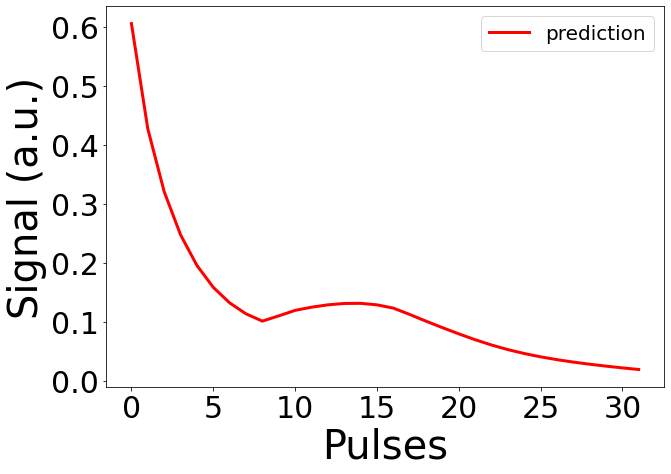

VF= 0.048439895158493056 R= 3.479170377927248 , SO2= 0.7376657485961914


In [142]:
##### COMPARABLE ONLY IF THE PARAMETERS ARE IN THE SAME ORDER

# show prediction example
# which_sample_to_test = np.random.choice(Test_List,1)[0]
which_sample_to_show = np.random.choice(n_signals_test,1)[0]
# which_sample_to_show = 520

# which_sample_to_test = 14130
print("Signal", which_sample_to_show, "used for plot")

font = {'color':  'black',
        'weight': 'normal',
        'size': 35,
        }
plt.rcParams["figure.figsize"] = (10,7)
fig = plt.figure(1)
plt.plot(pred_norm[which_sample_to_show],label='prediction', linewidth=3, color='r')
# plt.plot(gt_norm[which_sample_to_show],'--', label="ground_truth", linewidth=3, color='b')
# plt.plot(nodiff_norm[which_sample_to_show], '-', label='no_diffusion_signal', linewidth=3, color='k')

plt.legend(prop={'size': 20})
# plt.title("MR signals", fontdict=font)
plt.xlabel('Pulses', fontsize=40, fontdict=font)
plt.xticks(fontsize=30)
plt.ylabel('Signal (a.u.)', fontsize=40, fontdict=font)
plt.yticks(fontsize=30)
# plt.grid()	#shows a grid under the plot
plt.show()
print("VF=",parameters_test[which_sample_to_show,:,0][0], "R=", parameters_test[which_sample_to_show,:,1][0], ", SO2=", parameters_test[which_sample_to_show,:,2][0])
# print("VF=",sorted_parameters_for_sort[which_sample_to_show,0], "R=", sorted_parameters_for_sort[which_sample_to_show,1], ", SO2=", sorted_parameters_for_sort[which_sample_to_show,2], ", DH2O=", sorted_parameters_for_sort[which_sample_to_show,-1])



# print("NMRSE=", nrmse(prediction_test[which_sample_to_show, :, 0],diff_signal_test[which_sample_to_show])*100, "%")

In [60]:
# Define the dictionary with variable names and arrays
data = {'Parameters':parameters_test, 'MRSignals': prediction_test} #, 'VoxelList': voxelList_test}

# Save the data to a .mat file
save_path = "/data_network/summer/projects/Current/2021_MRF_TC/MRF_Simulations/dicoMRWAVES/RNN/Dico_GESFIDE_MRvF_2000PYTHON_noT2" + contrast + ".mat"
savemat(save_path, data)

## compute validation metrics between both dictionaries

In [316]:
#computing NRMSE between ground truth and prediction for 

nrmses = []
vf_values = []
r_values = []
so2_values = []

# Loop over all signals in Test_List to compute NRMSE
for sig in tqdm(range(n_signals_test), desc="Processing signals"):
    current_nrmse = nrmse(pred_norm[sig], gt_norm[sig]) * 100
    # Append the results
    nrmses.append(current_nrmse)
    vf_values.append(parameters_test[sig, :, 0][0])
    r_values.append(parameters_test[sig, :, 1][0])
    so2_values.append(parameters_test[sig, :, 2][0])

# Convert lists to numpy arrays for easier manipulation
nrmses = np.array(nrmses)
vf_values = np.array(vf_values) * 100
r_values = np.array(r_values)
so2_values = np.array(so2_values) * 100

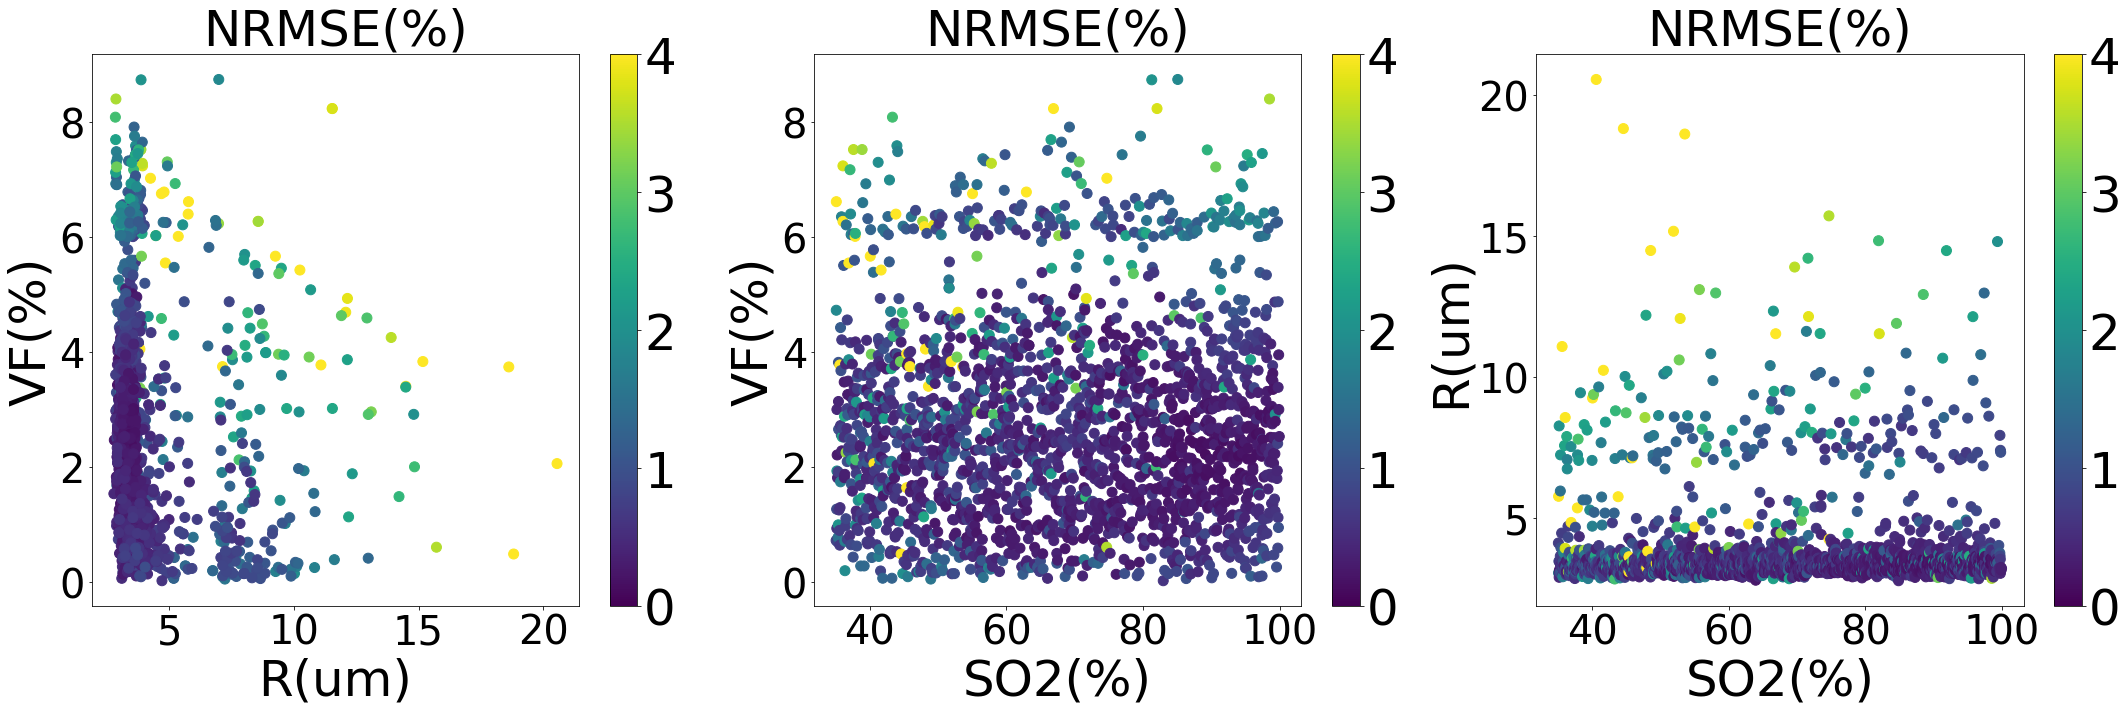

In [258]:


# Now create a 2D plot with NRMSE as surface color
def plot_surface(ax, x, y, z, xlabel, ylabel, zlabel):
    sc = ax.scatter(x, y, c=z, cmap='viridis', s=100, vmin=0, vmax=4)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.ax.tick_params(labelsize=50) 
    ax.set_xlabel(xlabel, fontsize=50)
    ax.set_ylabel(ylabel, fontsize=50)
    ax.tick_params(axis='both', which='major', labelsize=40)
    ax.set_title(f'{zlabel}', fontsize=50)



# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Plot NRMSE with all combinations of parameters
plot_surface(axs[0], r_values, vf_values, nrmses, 'R(um)', 'VF(%)', 'NRMSE(%)')
plot_surface(axs[1], so2_values, vf_values, nrmses, 'SO2(%)', 'VF(%)', 'NRMSE(%)')
plot_surface(axs[2], so2_values, r_values, nrmses, 'SO2(%)', 'R(um)', 'NRMSE(%)')

plt.tight_layout()
plt.show()